In [21]:
#pip install num2words
#pip install nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
from glob import glob
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from num2words import num2words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import re
from typing import List, Generator
import sqlalchemy
import pandas as pd
from urllib import parse
import json
from tqdm import tqdm
import subprocess
import os

In [22]:
def log(msg, flag=None):    
    if flag==None:
        flag = 0
    head = ["debug", "error", "status"]
    from time import gmtime, strftime
    now = strftime("%H:%M:%S", gmtime())
    if not os.path.isfile("./debug.log"):
        assert subprocess.call(f"echo \"[{now}][{head[flag]}] > {msg}\" > debug.log", shell=True)==0, print(f"[error] > shell command failed to execute")
    else: assert subprocess.call(f"echo \"[{now}][{head[flag]}] > {msg}\" >> debug.log", shell=True)==0, print(f"[error] > shell command failed to execute")

In [23]:
with open(f"..\\keys.json", "r", encoding='utf-8') as f:
    keys = json.load(f)
user = keys['user']
password = keys['password']
host = keys['host']
port = keys['port']
database = keys['database']
password = parse.quote_plus(password)
engine = sqlalchemy.create_engine(f"mysql://{user}:{password}@{host}:{port}/{database}?charset=utf8mb4")

In [24]:
def generate_doc_from_db(engine: sqlalchemy.Engine, table_name: str, yield_size: int = 1000):
    query = f"SELECT * FROM {table_name} LIMIT 1000"
    with engine.connect() as conn:
        log("connection established")
        proxy = conn.execution_options(stream_results=True).execute(sqlalchemy.text(query))
        try:
            while 'batch not empty':
                batch = proxy.fetchmany(yield_size)
                if not batch:
                    break
                for row in batch:
                    yield row
        finally:
            log("disconnecting...")
            proxy.close()  # Ensure the result set is closed properly

In [25]:
# test 
def generate_doc():
    news_contents = glob("..\\news_contents\\*.txt")
    raw_docs = []
    for f_name in news_contents:
        with open(f_name, "r", encoding='utf-8') as f:
            raw_docs.append(f.read())
    yield from raw_docs

In [26]:
def preprocessing(documents):
    stop_words = set(stopwords.words("english"))
    wordnet_lemmatizer = WordNetLemmatizer()
    iterate_counter = 0
    for text in tqdm(documents):
        log(f"iterate counter = {iterate_counter}")
        text = str(text).lower()
        tokens = word_tokenize(text)
        tokens = [i.replace(",", "") for i in tokens]
        tokens = [num2words(i) if i.isdigit() else i for i in tokens]
        adj_text = " ".join(tokens)
        adj_text = re.sub(r'^[^a-z]', ' ', adj_text)
        tokens = word_tokenize(adj_text)
        tokensWSW = [word for word in tokens if word not in stop_words]
        lemmatized_list = [wordnet_lemmatizer.lemmatize(word) for word in tokensWSW]
        clean_text = " ".join(lemmatized_list)
        iterate_counter += 1
        yield clean_text

In [27]:
def calculate_tfidf(documents_generator):
    log("calculating tf id matrix...")
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents_generator)
    return tfidf_matrix

In [28]:
def calculate_cosine_similarity(tfidf_matrix):
    log(f"calculating cosine similarity...")
    # 코사인 유사도 계산
    similarity_matrix = cosine_similarity(tfidf_matrix)
    log(f"cosine similarity calculated")
    return similarity_matrix

In [29]:
def clustering_model(similarity_matrix):
    log(f"clustering...")
    # 계층적 병합 클러스터링 수행
    clustering = linkage(similarity_matrix, method='ward')
    log(f"complete.")
    return clustering

In [30]:
documents_generator = generate_doc_from_db(engine, keys['table'])
preprocessing_documents =  preprocessing(documents_generator)
tfidf_matrix = calculate_tfidf(preprocessing_documents)
similarity_matrix = calculate_cosine_similarity(tfidf_matrix)
clustering = clustering_model(similarity_matrix)

0it [00:00, ?it/s]

1000it [00:15, 64.08it/s]


In [31]:
def plot_dendrogram(clustering, labels):
    plt.figure(figsize=(10, 7))
    dendrogram(clustering, labels=labels, orientation='right')
    plt.xlabel('Distance')
    plt.ylabel('Document')
    plt.title('Hierarchical Clustering Dendrogram')
    plt.show()



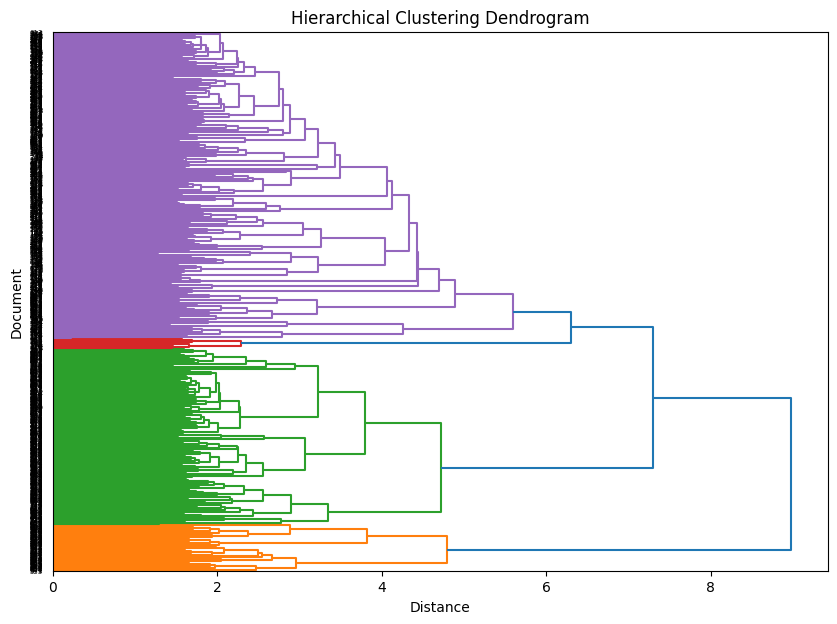

In [33]:
plot_dendrogram(clustering, labels=None)

In [ ]:
# merge_test